# Market evaluation demo

This notebook builds 2‑hour windows from BBO‑1s data, simulates TWAP (and optionally a PINN), and plots cost–variance and per‑window overlays.

In [10]:
%load_ext autoreload
%autoreload 2


import pandas as pd
from market_eval import (
    make_intraday_windows, windows_from_list,
    TWAPPolicy,
    evaluate_models_over_windows, compute_cost_variance_points, plot_cost_variance_scatter, summarize_cost_variance, plot_window_overlay,
    plot_spy_prices, plot_spy_prices_bbg, simple_T_sigma_srange, PINNPolicy, 
)
from loading_helper import load_model_and_history

paths = [
    'stock_data/SPY-XNAS-20250821-8HPB68JK9Q/xnas-itch-20250210.bbo-1s.csv.zst',
    'stock_data/SPY-XNAS-20250821-8HPB68JK9Q/xnas-itch-20250211.bbo-1s.csv.zst',
    'stock_data/SPY-XNAS-20250821-8HPB68JK9Q/xnas-itch-20250212.bbo-1s.csv.zst',
    'stock_data/SPY-XNAS-20250821-8HPB68JK9Q/xnas-itch-20250213.bbo-1s.csv.zst',
    'stock_data/SPY-XNAS-20250821-8HPB68JK9Q/xnas-itch-20250214.bbo-1s.csv.zst',
    'stock_data/SPY-XNAS-20250821-8HPB68JK9Q/xnas-itch-20250218.bbo-1s.csv.zst',
    'stock_data/SPY-XNAS-20250821-8HPB68JK9Q/xnas-itch-20250219.bbo-1s.csv.zst',
]

combined_df, raw_windows = make_intraday_windows(paths, start_times=("09:45","11:45","13:45"), duration="2h", grid_freq="5s", min_coverage=0.80)
print("Combined shape:", combined_df.shape)
print("Unique windows:", combined_df["window_id"].nunique())
Ws = windows_from_list(raw_windows)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Combined shape: (30240, 5)
Unique windows: 21


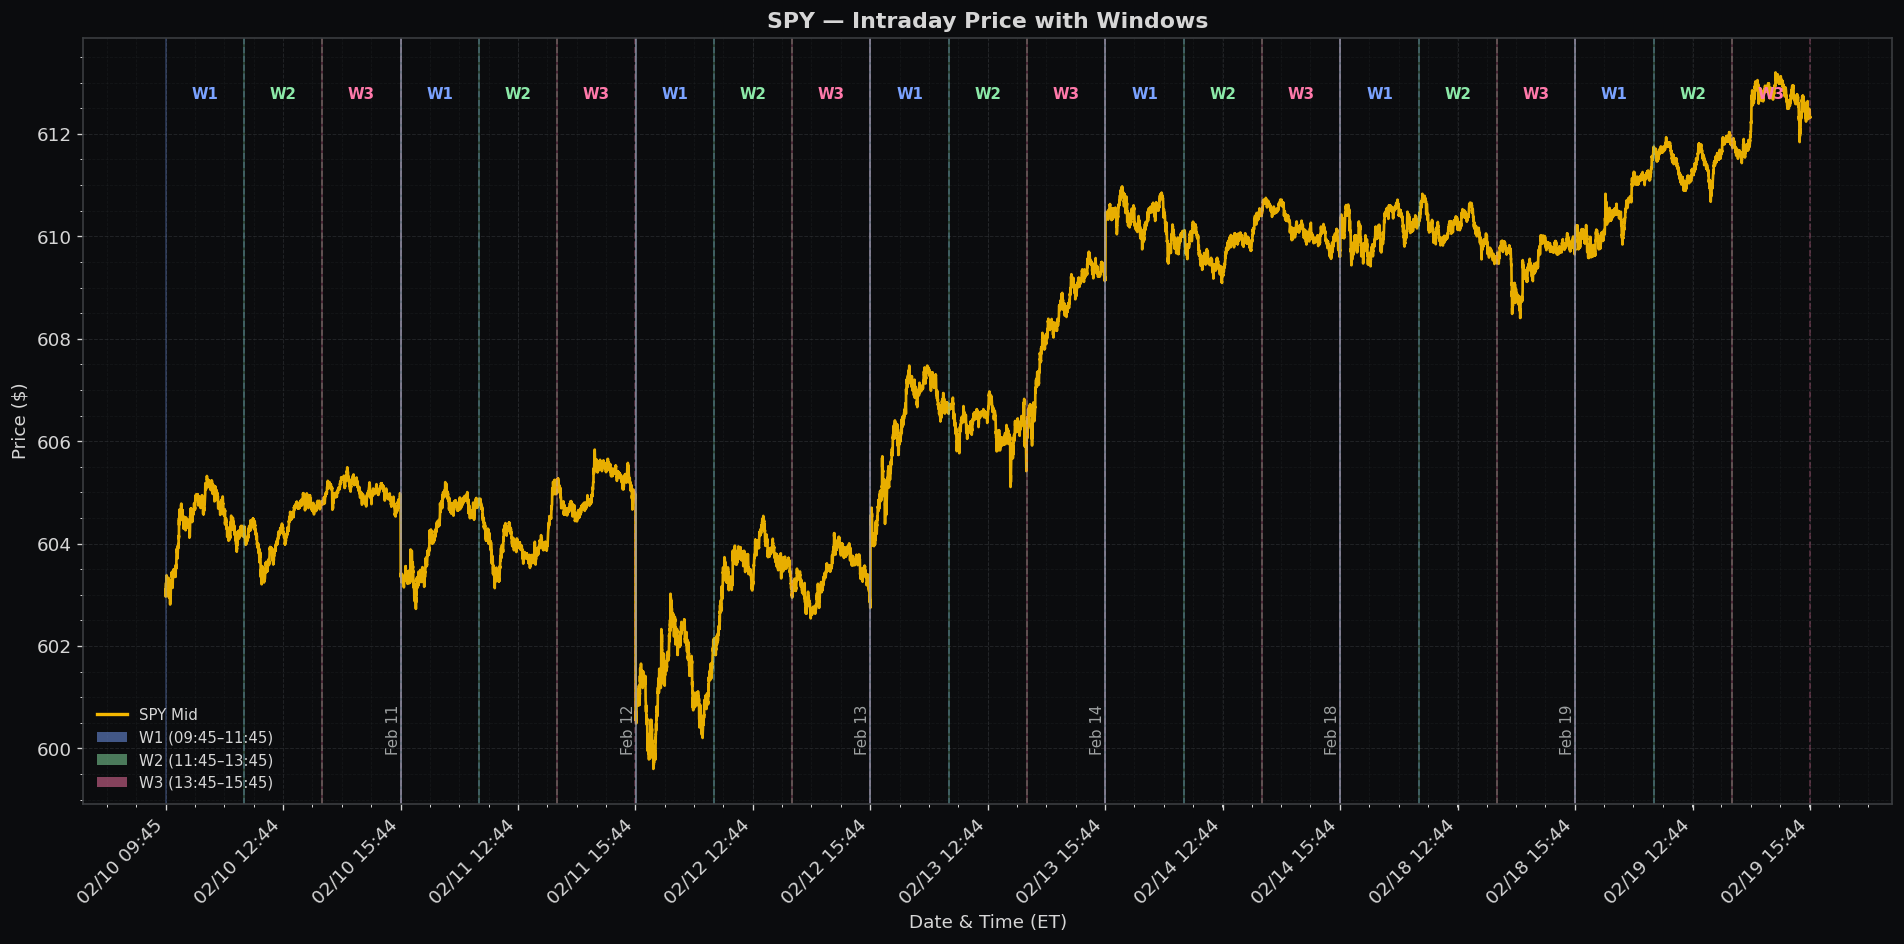


=== Summary Statistics ===
Date range: 2025-02-10 to 2025-02-19
Price range: $599.60 - $613.20
Total windows: 21
Data points: 30,240
Windows per day:
  2025-02-10: Windows [np.int64(1), np.int64(2), np.int64(3)]
  2025-02-11: Windows [np.int64(1), np.int64(2), np.int64(3)]
  2025-02-12: Windows [np.int64(1), np.int64(2), np.int64(3)]
  2025-02-13: Windows [np.int64(1), np.int64(2), np.int64(3)]
  2025-02-14: Windows [np.int64(1), np.int64(2), np.int64(3)]
  2025-02-18: Windows [np.int64(1), np.int64(2), np.int64(3)]
  2025-02-19: Windows [np.int64(1), np.int64(2), np.int64(3)]


In [11]:
#plot_spy_prices(combined_df)
plot_spy_prices_bbg(combined_df)

In [321]:
print(simple_T_sigma_srange(Ws))

{'T_days': 0.3074786324786325, 'sigma_day': 0.0038256296985648857, 's_range': (600.74195, 612.88)}


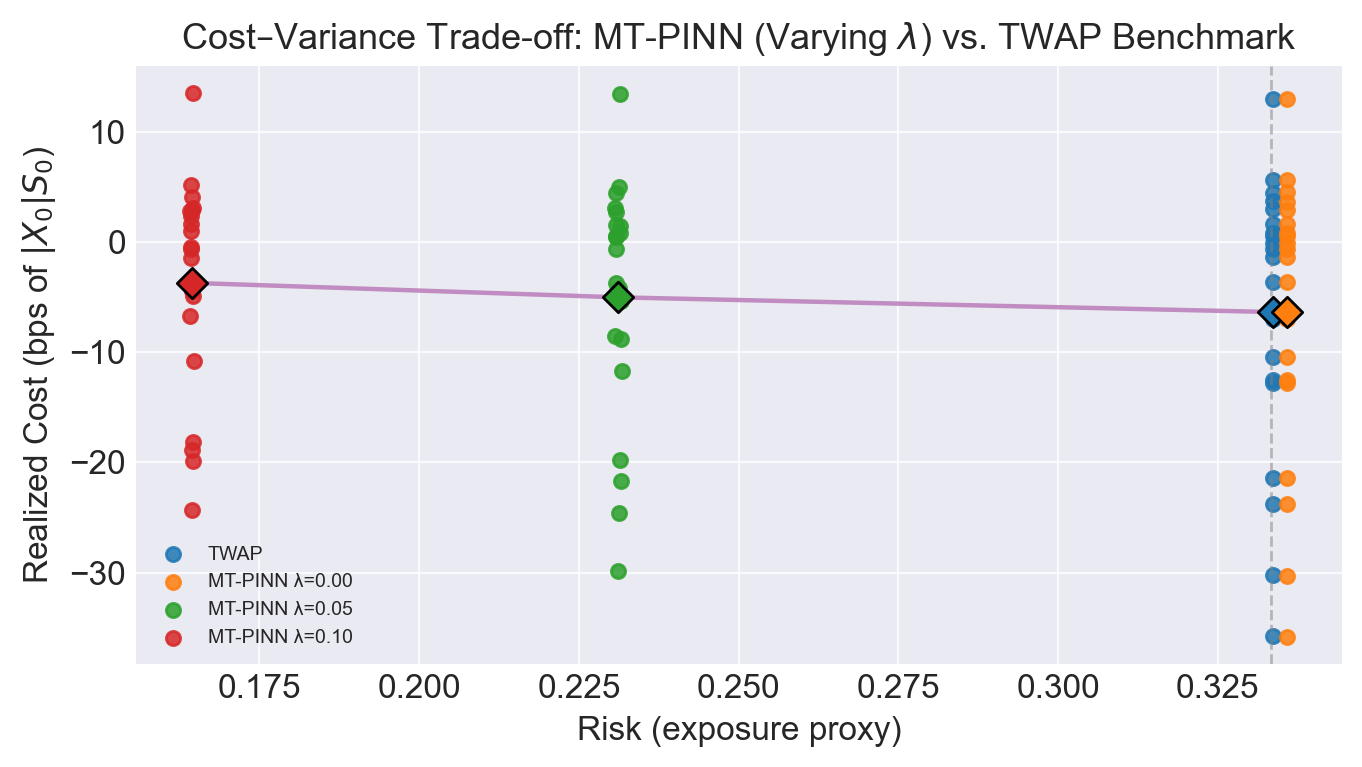

In [ ]:
# Load checkpoints
specs = [
    ("MT-PINN λ=0.00", "runs/market/market_1", "2d_lam0",  False),
    ("MT-PINN λ=0.05", "runs/market/market_2", "alpha_1p0", True),
    ("MT-PINN λ=0.10", "runs/market/market_3", "alpha_1p0", True),
]

models = {"TWAP": TWAPPolicy()}
for name, run_dir, tag, use_S in specs:
    _, params, cfg, _ = load_model_and_history(run_dir, tag)
    models[name] = PINNPolicy(cfg, params, use_S=use_S, name=name)


results, extras = evaluate_models_over_windows(models, Ws, X0_shares=10_000)

# ---- Cost–variance points + plot
points = compute_cost_variance_points(results, models)
order = ["TWAP", "MT-PINN λ=0.00", "MT-PINN λ=0.05", "MT-PINN λ=0.10"]
connect = ["MT-PINN λ=0.00", "MT-PINN λ=0.05", "MT-PINN λ=0.10"]

plot_cost_variance_scatter(points, order=order, connect_order=connect)

In [325]:
pts = compute_cost_variance_points(results, models=models)
print(summarize_cost_variance(pts).round(10))

            model  exposure_mean  exposure_std  cost_bps_mean  cost_bps_std  \
0  MT-PINN λ=0.00       0.335888      0.000000      -6.372262     12.575197   
1  MT-PINN λ=0.05       0.231143      0.000360      -5.007133     11.022631   
2  MT-PINN λ=0.10       0.164406      0.000155      -3.694912      9.666591   
3            TWAP       0.333681      0.000000      -6.353804     12.562659   

    n  
0  21  
1  21  
2  21  
3  21  


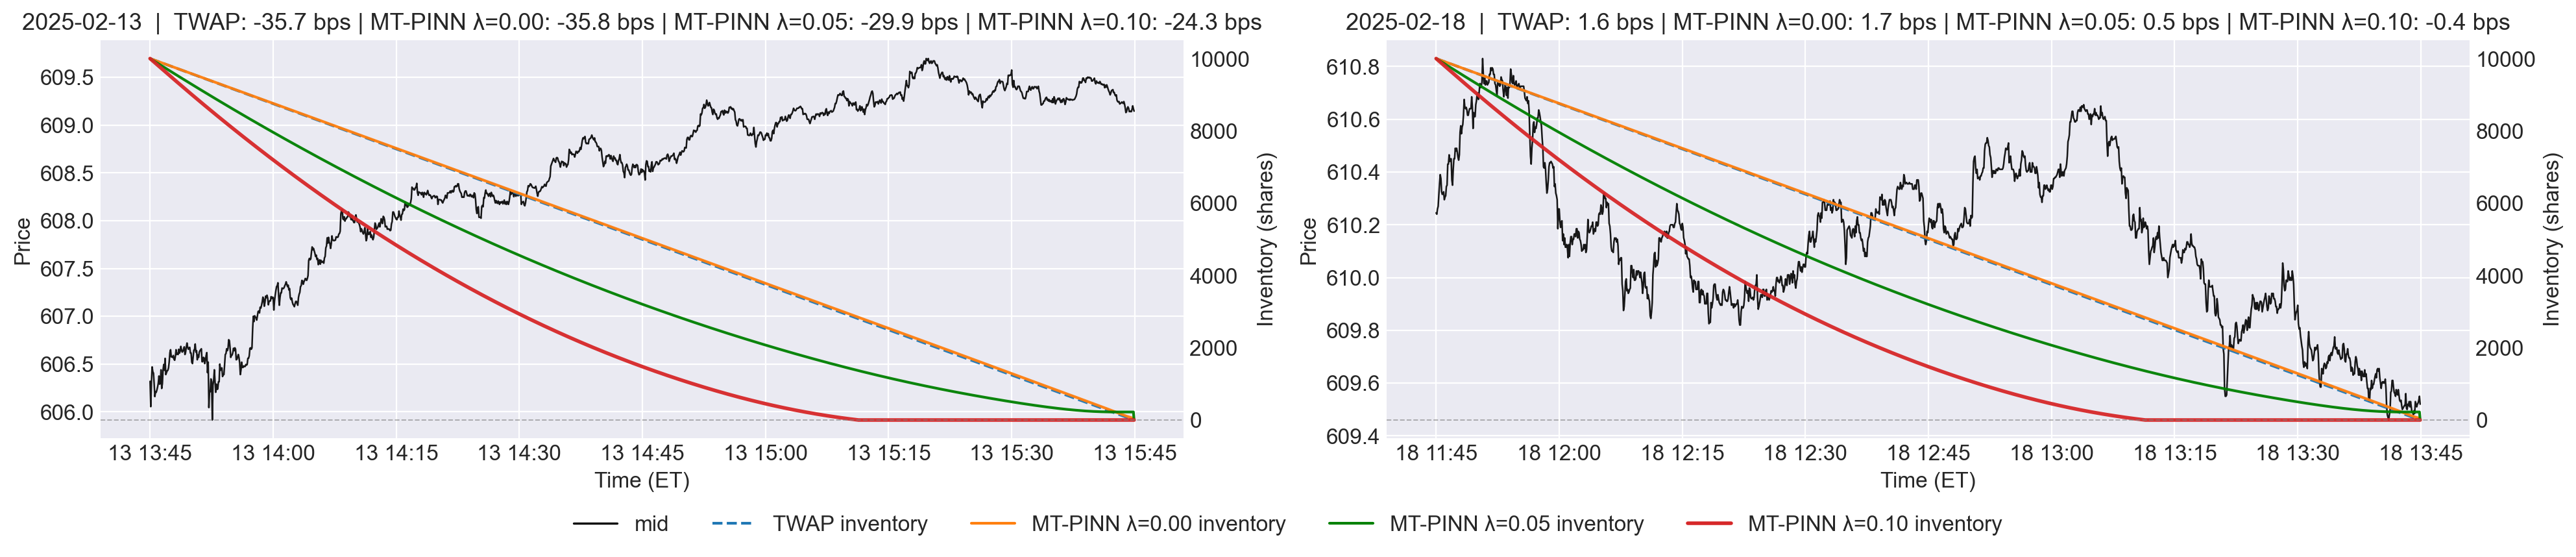

In [326]:
ids = [Ws[11].window_id, Ws[16].window_id] # Ws[9].window_id Ws[11].window_id, Ws[14].window_id,
traj = extras.get("trajectories", {})
multi_payload = {
    wid: {name: traj[name][wid] for name in models if wid in traj.get(name, {})}
    for wid in ids
}
plot_window_overlay(multi_payload, ncols=2)